# PyTorch LSTM NN to determine the patterns in the shape only, but not the colours.

**Overview**

LSTM are designed to handle sequential dependencies which is why this model was investigated as a possible solution for recognising and understanding the underlying pattern in the input-output pattern in the data; as a potential solution for discovering 2d sequences in grids of data, i.e. matrices. 

**Conclusion**

 However, the LSTM model seems to not perform well, likely due to its inability to have extensive reasoning over the complicated data structures. That is to say, the ARC-AGI task involves static input grids where spatial relationships rather than temporal sequences are crucial, which is likely why the LSTM has failed. Essentially, the novel and diverse data pattern distributions seems to be creating difficulties in recognising and inferring rules.

The task in ARC-AGI leans more towards pattern recognition and rule-based reasoning, which requires specialized approaches tailored to spatial relationships and transformations rather than sequential dependencies.

In [92]:
import warnings
warnings.filterwarnings("ignore")
import os
import json
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300


### Load data

In [79]:

# Define the paths to the training and evaluation directories
training_task_path = os.path.join(os.path.expanduser('~'), 'kaiko/ARC-AGI-NLP-HACK/data/training')
evaluation_task_path = os.path.join(os.path.expanduser('~'), 'kaiko/ARC-AGI-NLP-HACK/data/evaluation')

def load_tasks(task_directory):
    tasks = []
    for filename in os.listdir(task_directory):
        if filename.endswith('.json'):
            file_path = os.path.join(task_directory, filename)
            print(f"Loading task from file: {file_path}")
            try:
                with open(file_path, 'r') as f:
                    task = json.load(f)
                    tasks.append(task)
            except Exception as e:
                print(f"Error loading task from {file_path}: {e}")
    return tasks

def extract_train_and_test(tasks):
    train_data = []
    test_data = []
    for task in tasks:
        try:
            train_data.append(task['train'])
            test_data.append(task['test'])
        except KeyError as e:
            print(f"KeyError: {e} in task: {task}")
    return train_data, test_data

# Load the training tasks
try:
    training_tasks = load_tasks(training_task_path)
    print("Training tasks loaded successfully.")
except Exception as e:
    print(f"Error loading training tasks: {e}")

# Load the evaluation tasks
try:
    evaluation_tasks = load_tasks(evaluation_task_path)
    print("Evaluation tasks loaded successfully.")
except Exception as e:
    print(f"Error loading evaluation tasks: {e}")

Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/a85d4709.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/c8cbb738.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/8e1813be.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/a699fb00.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/5c2c9af4.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/44f52bb0.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/23581191.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/94f9d214.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/f9012d9b.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/4258a5f9.json
Loading task from file: /Users/Ciaran/kaiko/ARC-AGI-NLP-HACK/data/training/bdad9b1f.json
Loading task from fil

In [80]:
# Extract training and testing data
try:
    training_train_data, training_test_data = extract_train_and_test(training_tasks)
    evaluation_train_data, evaluation_test_data = extract_train_and_test(evaluation_tasks)
except Exception as e:
    print(f"Error extracting training and testing data: {e}")

# Print out some details to verify
print(f"Number of training tasks: {len(training_tasks)}")
print(f"Number of evaluation tasks: {len(evaluation_tasks)}")

Number of training tasks: 400
Number of evaluation tasks: 400


### Examine the data

In [89]:
# Function to count and sort input-output pair sizes
def count_and_sort_size_pairs(tasks):
    size_counts = defaultdict(int)

    # Iterate through all tasks
    for task in tasks:
        for train_pair in task['train']:
            input_grid = train_pair['input']
            output_grid = train_pair['output']

            # Determine the dimensions (size) of input and output grids
            input_size = f"{len(input_grid)} x {len(input_grid[0])} grid"
            output_size = f"{len(output_grid)} x {len(output_grid[0])} grid"

            # Increment the count for this size pair
            size_counts[(input_size, output_size)] += 1

    # Sort size_counts by count values (descending order)
    sorted_counts = sorted(size_counts.items(), key=lambda item: item[1], reverse=True)

    return sorted_counts

# Count and sort input-output pair sizes for training data
sorted_training_counts = count_and_sort_size_pairs(training_tasks)

# Count and sort input-output pair sizes for evaluation data
sorted_evaluation_counts = count_and_sort_size_pairs(evaluation_tasks)

# Print the counts for training data in sorted order
print("Training Data:")
for (input_size, output_size), count in sorted_training_counts:
    print(f"{input_size}: {output_size}: {count} training data training pairs found")


# Print the counts for evaluation data in sorted order
print("\nEvaluation Data:")
for (input_size, output_size), count in sorted_evaluation_counts:
    print(f"{input_size}: {output_size}: {count} eval data training pairs found")

Training Data:
10 x 10 grid: 10 x 10 grid: 171 training data training pairs found
3 x 3 grid: 3 x 3 grid: 77 training data training pairs found
9 x 9 grid: 9 x 9 grid: 32 training data training pairs found
15 x 15 grid: 15 x 15 grid: 30 training data training pairs found
12 x 12 grid: 12 x 12 grid: 26 training data training pairs found
5 x 5 grid: 5 x 5 grid: 22 training data training pairs found
6 x 6 grid: 6 x 6 grid: 21 training data training pairs found
7 x 7 grid: 7 x 7 grid: 21 training data training pairs found
20 x 20 grid: 20 x 20 grid: 21 training data training pairs found
3 x 3 grid: 6 x 6 grid: 20 training data training pairs found
3 x 3 grid: 9 x 9 grid: 19 training data training pairs found
13 x 13 grid: 13 x 13 grid: 16 training data training pairs found
11 x 11 grid: 11 x 11 grid: 16 training data training pairs found
3 x 3 grid: 1 x 1 grid: 14 training data training pairs found
8 x 8 grid: 8 x 8 grid: 14 training data training pairs found
10 x 10 grid: 3 x 3 grid: 14 t

In [91]:
# Print the counts for evaluation data in sorted order
print("\nEvaluation Data:")
for (input_size, output_size), count in sorted_evaluation_counts:
    print(f"{input_size}: {output_size}: {count} training pairs found")


Evaluation Data:
10 x 10 grid: 10 x 10 grid: 114 training pairs found
15 x 15 grid: 15 x 15 grid: 46 training pairs found
30 x 30 grid: 30 x 30 grid: 42 training pairs found
3 x 3 grid: 9 x 9 grid: 37 training pairs found
12 x 12 grid: 12 x 12 grid: 33 training pairs found
13 x 13 grid: 13 x 13 grid: 31 training pairs found
20 x 20 grid: 20 x 20 grid: 21 training pairs found
6 x 6 grid: 6 x 6 grid: 20 training pairs found
7 x 7 grid: 7 x 7 grid: 20 training pairs found
11 x 11 grid: 11 x 11 grid: 19 training pairs found
16 x 16 grid: 16 x 16 grid: 18 training pairs found
3 x 3 grid: 6 x 6 grid: 17 training pairs found
23 x 23 grid: 23 x 23 grid: 15 training pairs found
9 x 9 grid: 9 x 9 grid: 15 training pairs found
3 x 3 grid: 3 x 3 grid: 14 training pairs found
19 x 19 grid: 19 x 19 grid: 14 training pairs found
22 x 22 grid: 22 x 22 grid: 12 training pairs found
14 x 14 grid: 14 x 14 grid: 11 training pairs found
7 x 7 grid: 3 x 3 grid: 10 training pairs found
17 x 17 grid: 17 x 17

## PyTorch LSTM NN for shape

### Process the data

In [66]:
# Extract input-output pairs from JSON data
X = []
y = []
max_shape = None

for inner_list in training_train_data:
    for json_obj in inner_list:
        input_arr = np.array(json_obj['input'])
        output_arr = np.array(json_obj['output'])
        
        # Determine maximum shape
        if max_shape is None:
            max_shape = input_arr.shape
        else:
            max_shape = tuple(max(max_shape[i], input_arr.shape[i]) for i in range(len(max_shape)))
        
        X.append(input_arr)
        y.append(output_arr)

# Numpy expects arrays to be the same so apply padding to the maximal shape
for i in range(len(X)):
    X[i] = np.pad(X[i], [(0, max_shape[0] - X[i].shape[0]), (0, max_shape[1] - X[i].shape[1])], mode='constant')
    y[i] = np.pad(y[i], [(0, max_shape[0] - y[i].shape[0]), (0, max_shape[1] - y[i].shape[1])], mode='constant')

# Convert lists of arrays to NumPy arrays
X = np.array(X)
y = np.array(y)


In [67]:
# Print shapes to verify
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# 1302 samples with 30 rows and 30 columns

Shape of X: (1302, 30, 30)
Shape of y: (1302, 30, 30)


### Build the model

In [77]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# Function to calculate MAE, RMSE, and R-squared
def evaluate_metrics(outputs, targets):
    outputs_flat = outputs.view(-1, outputs.shape[-1])
    targets_flat = targets.view(-1, targets.shape[-1])
    
    mae = mean_absolute_error(targets_flat.cpu().detach().numpy(), outputs_flat.cpu().detach().numpy())
    rmse = mean_squared_error(targets_flat.cpu().detach().numpy(), outputs_flat.cpu().detach().numpy(), squared=False)
    r2 = r2_score(targets_flat.cpu().detach().numpy(), outputs_flat.cpu().detach().numpy())
    
    return mae, rmse, r2

# Function to visualize training metrics
def plot_metrics(train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse, train_r2, val_r2):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Metrics (MAE, RMSE, R2)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_mae, label='Train MAE')
    plt.plot(epochs, val_mae, label='Val MAE')
    plt.plot(epochs, train_rmse, label='Train RMSE')
    plt.plot(epochs, val_rmse, label='Val RMSE')
    plt.plot(epochs, train_r2, label='Train R2')
    plt.plot(epochs, val_r2, label='Val R2')
    plt.title('Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R2)')
    plt.xlabel('Epoch')
    plt.ylabel('Error / R2')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Prepare the data

In [75]:
# Data augmentation functions
def random_time_shifts(X, max_shift):
    ''' 
    Move data forward or backwars in time by a random number of steps.
    This ensures that the model can still recognize patterns even if they 
    occur at slightly different times.
    '''
    batch_size, seq_len, input_dim = X.size()
    shifts = torch.randint(-max_shift, max_shift + 1, size=(batch_size,))
    X_shifted = X.clone()  # Create a copy to avoid in-place modification error
    for i in range(batch_size):
        shift = shifts[i]
        if shift == 0:
            continue
        elif shift > 0:
            X_shifted[i, shift:] = X[i, :-shift].clone()
            X_shifted[i, :shift] = 0  # Pad with zeros
        else:
            X_shifted[i, :shift] = X[i, -shift:].clone()
            X_shifted[i, shift:] = 0  # Pad with zeros
    return X_shifted

def random_scaling(X, min_scale=0.8, max_scale=1.2):
    '''
    Multiplying the data points in the sequence by a random factor.
    Helps the model become invariant to changes in the amplitude of the signal.
    '''
    batch_size, seq_len, input_dim = X.size()
    scales = torch.empty(batch_size).uniform_(min_scale, max_scale)
    X_scaled = X.clone()
    for i in range(batch_size):
        X_scaled[i] *= scales[i]
    return X_scaled

def add_noise(X, noise_std=0.1):
    '''
    Generates a tensor of random values drawn from a standard normal distribution 
    (mean = 0, standard deviation = 1) with the same shape as X.
    '''
    noise = torch.randn_like(X) * noise_std
    return X + noise

def augment_data(X, y, max_shift=10, min_scale=0.8, max_scale=1.2, noise_std=0.1):
    X_augmented = random_time_shifts(X.clone(), max_shift)
    X_augmented = random_scaling(X_augmented, min_scale, max_scale)
    X_augmented = add_noise(X_augmented, noise_std)
    return X_augmented, y

In [76]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Assuming you have train-test split, split your data
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size

train_X, val_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, val_y = y_tensor[:train_size], y_tensor[train_size:]

train_X_augmented, train_y_augmented = augment_data(train_X, train_y)

# Create DataLoader for augmented data
batch_size = 16
train_dataset = TensorDataset(train_X_augmented, train_y_augmented)
val_dataset = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Run the model

Epoch [1/100], Train Loss: 1.1017, Val Loss: 1.1451
Epoch [1/100], Train MAE: 0.2980, Val MAE: 0.3549
Epoch [1/100], Train RMSE: 0.8216, Val RMSE: 0.8130
Epoch [1/100], Train R2 Score: -0.0717, Val R2 Score: 0.0070
Epoch [2/100], Train Loss: 0.9965, Val Loss: 1.0519
Epoch [2/100], Train MAE: 0.3161, Val MAE: 0.3165
Epoch [2/100], Train RMSE: 0.7794, Val RMSE: 0.7798
Epoch [2/100], Train R2 Score: -0.0467, Val R2 Score: 0.0567
Epoch [3/100], Train Loss: 0.9526, Val Loss: 0.9983
Epoch [3/100], Train MAE: 0.3058, Val MAE: 0.3380
Epoch [3/100], Train RMSE: 0.7695, Val RMSE: 0.7698
Epoch [3/100], Train R2 Score: -0.1279, Val R2 Score: 0.0623
Epoch [4/100], Train Loss: 0.8950, Val Loss: 0.9846
Epoch [4/100], Train MAE: 0.3093, Val MAE: 0.3526
Epoch [4/100], Train RMSE: 0.7574, Val RMSE: 0.7714
Epoch [4/100], Train R2 Score: -0.1068, Val R2 Score: 0.0411
Epoch [5/100], Train Loss: 0.9873, Val Loss: 0.9738
Epoch [5/100], Train MAE: 0.3404, Val MAE: 0.3532
Epoch [5/100], Train RMSE: 0.7719, Val

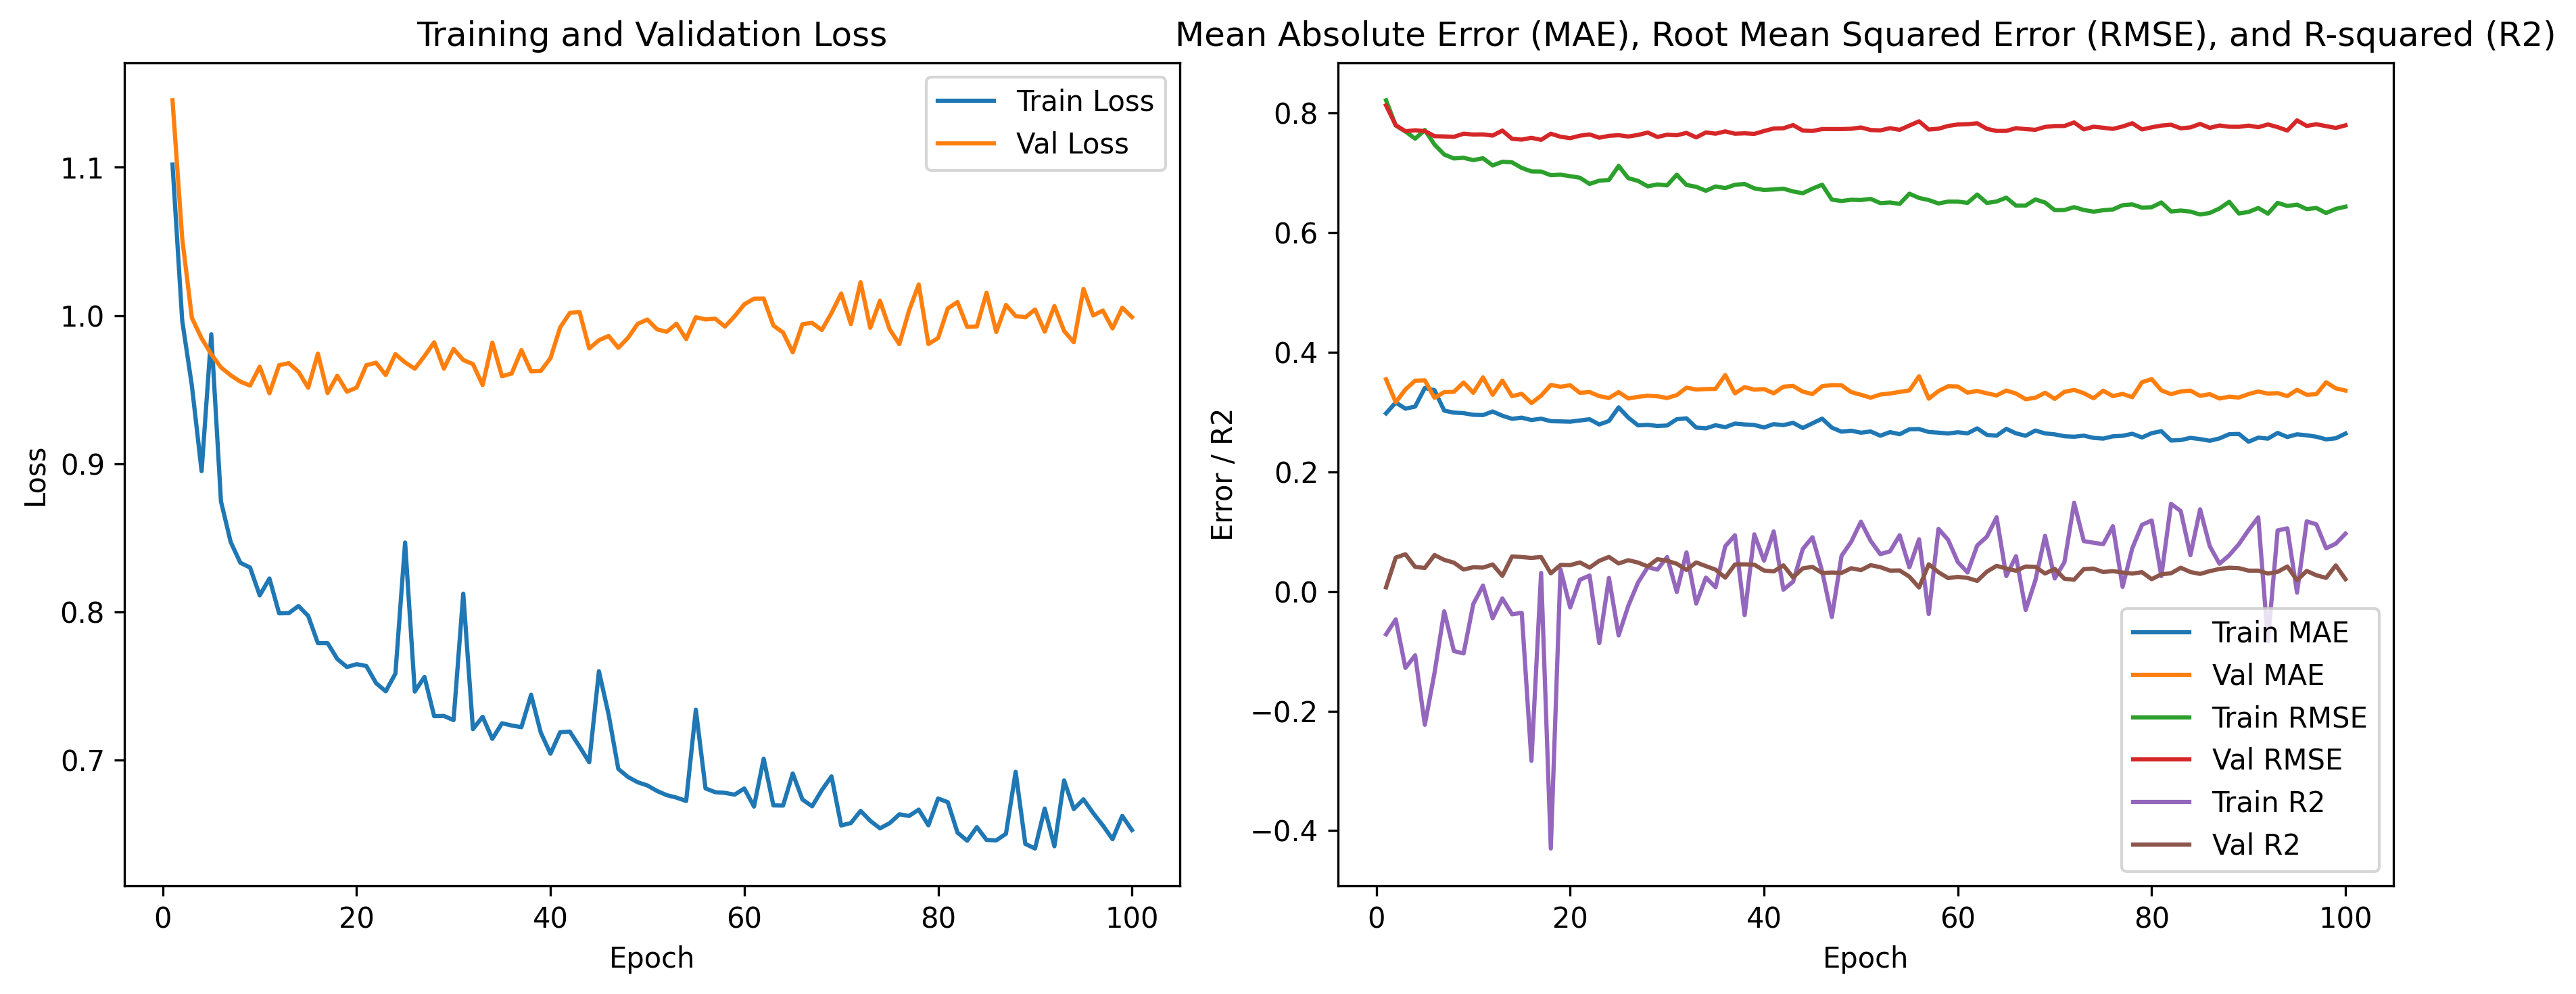

In [93]:
# Initialize model, loss function, and optimizer
input_size = X_tensor.size(2)  # Assuming X_tensor.shape[2] is input_size
hidden_size = 32  # Example hidden size, adjust based on data.
output_size = y_tensor.size(2)  # Assuming y_tensor.shape[2] is output_size
num_layers = 1    # Example number of layers. Low as to prevent overfitting.

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_rmses = []
val_rmses = []
train_r2s = []
val_r2s = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_mae = 0.0
    epoch_rmse = 0.0
    epoch_r2 = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        # Ensure batch_X has the correct shape (batch_size, seq_length, input_size)
        if batch_X.dim() == 2:
            batch_X = batch_X.unsqueeze(1)

        # Forward pass
        outputs = model(batch_X)

        # Ensure batch_y matches the expected shape
        if batch_y.dim() == 2:
            batch_y = batch_y.unsqueeze(1)  # Ensure it has shape (batch_size, output_size, output_size)

        # Ensure outputs and batch_y have the same shape
        if outputs.shape != batch_y.shape:
            raise ValueError(f"Output shape {outputs.shape} does not match target shape {batch_y.shape}")

        # Compute loss
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Calculate metrics (MAE, RMSE, R2)
        batch_mae, batch_rmse, batch_r2 = evaluate_metrics(outputs, batch_y)
        epoch_mae += batch_mae
        epoch_rmse += batch_rmse
        epoch_r2 += batch_r2

    # Average loss and metrics for the epoch
    epoch_loss /= len(train_loader)
    epoch_mae /= len(train_loader)
    epoch_rmse /= len(train_loader)
    epoch_r2 /= len(train_loader)

    # Append metrics to lists as tensors
    train_losses.append(epoch_loss)
    train_maes.append(epoch_mae)
    train_rmses.append(epoch_rmse)
    train_r2s.append(epoch_r2)
      
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_mae = 0.0
        val_rmse = 0.0
        val_r2 = 0.0

        for batch_X, batch_y in val_loader:
            # Ensure batch_X has the correct shape
            if batch_X.dim() == 2:
                batch_X = batch_X.unsqueeze(1)

            outputs = model(batch_X)

            # Ensure batch_y matches the expected shape
            if batch_y.dim() == 2:
                batch_y = batch_y.unsqueeze(1)  # Ensure it has shape (batch_size, output_size, output_size)

            # Ensure outputs and batch_y have the same shape
            if outputs.shape != batch_y.shape:
                raise ValueError(f"Output shape {outputs.shape} does not match target shape {batch_y.shape}")

            # Compute validation loss
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            # Calculate validation metrics (MAE, RMSE, R2)
            batch_mae, batch_rmse, batch_r2 = evaluate_metrics(outputs, batch_y)
            val_mae += batch_mae
            val_rmse += batch_rmse
            val_r2 += batch_r2

        # Average validation loss and metrics
        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_rmse /= len(val_loader)
        val_r2 /= len(val_loader)

        # Append validation metrics to lists as tensors
        val_losses.append(val_loss)
        val_maes.append(val_mae)
        val_rmses.append(val_rmse)
        val_r2s.append(val_r2)

    # Print or log the metrics for debugging if needed
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train MAE: {epoch_mae:.4f}, Val MAE: {val_mae:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train RMSE: {epoch_rmse:.4f}, Val RMSE: {val_rmse:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train R2 Score: {epoch_r2:.4f}, Val R2 Score: {val_r2:.4f}')

# Plot metrics after training loop
plot_metrics(train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses, train_r2s, val_r2s)